In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
FS=20
matplotlib.rcParams.update({'font.size': FS}) # set font size

## Exploring results files
Lets examine the current folder to see which parameter sweeps are available.

In [2]:
folder='data_for_paper\\'
files=os.listdir(folder)
dates=set()
params=[]
for file in files:
    if ".xlsx" in file:
        dates.add(file.split('_')[-1].split('.')[0])
dates=sorted(list(dates),reverse=True)
for date in dates:
    for file in files:
        if date in file:
            startind=file.find('results_')+8
            endind=file.find('_sweep',startind)
            params.append(file[startind:endind])
            break
file_df=pd.DataFrame()
file_df['Dates']=dates
file_df['Parameter']=params
display(file_df)

,Dates,Parameter
0,20190107-173903,mu_freq
1,20181219-163117,coupling_function
2,20181219-131550,p_erdos_renyi
3,20181219-103647,sigma_freq
4,20181219-095350,tmax
5,20181219-012111,num_repeats
6,20181218-170411,num_osc


The functions below will be used to create a dataframe with the data from the csv files.

In [4]:
def get_param_val_run(df):
    params=[]
    vals=[]
    runs=[]
    networks=[]
    for col in df.index:
        col=col.replace(',','=')
        tmp_list=col.split("=")
        params.append(tmp_list[0].replace(' ',''))
        vals.append(tmp_list[1].replace(' ',''))
        networks.append(tmp_list[2].split(' ')[2])
        runs.append(int(tmp_list[4].replace(' ','')))
    df['parameter']=params
    df['parameter value']=vals
    df['network']=networks
    df['run number']=runs
    df.rename(columns={0:'Validation Error'},inplace=True)
    return df

## Displaying results 
Now, we can import the data from the csv files, clean up the data types and display the last few rows in the resulting dataframes.  

In [5]:
index=6  # select the file to load by changing this variable
timestr=dates[index]
loop_parameter=params[index]
filename_suffix=str(loop_parameter) +'_sweep_'+ str(timestr)

w_df=pd.read_excel(folder+'frequency_results_'+ filename_suffix+'.xlsx',index_col=0).T
f_df=pd.read_excel(folder+'coupling_function_results_'+ filename_suffix +'.xlsx',index_col=0).T
A_df=pd.read_excel(folder+'adjacency_matrix_results_'+ filename_suffix +'.xlsx',index_col=0).T
e_df=pd.read_excel(folder+'validation_error_results_'+ filename_suffix +'.xlsx',index_col=0)
e_df=get_param_val_run(e_df.T).rename(columns={'parameter':'loop_parameter','parameter value':'parameter'})

if False: # replace False with True if you want to see them
    display(w_df.head())
    display(A_df.head())
    display(f_df.head())
    display(e_df.head())

## Extracting the best run:
Now lets select only the run with the lowest validation error

In [6]:
idx=e_df.groupby(['network','parameter'])['Validation Error'].idxmin().values
A_df=A_df.loc[idx,:].sort_values(by=['parameter','network'])
w_df=w_df.loc[idx,:].sort_values(by=['parameter','network'])
f_df=f_df.loc[idx,:].sort_values(by=['parameter','network'])
e_df=e_df.loc[idx,:].sort_values(by=['parameter','network'])
if False: # replace False with True if you want to see them
    display(w_df.head())
    display(A_df.head())
    display(f_df.head())
    display(e_df.head())

## Plot functions
Here we define dictionaries that can be used to use different labels in the plot than in the data frame.  You can add entries for new categories (`cat_name_dict`) and parameters (`parameter_name_dict`).

In [7]:
import seaborn as sns
cat_name_dict={'Area ratio': 'Area Ratio ($\Gamma$)',#r'$\frac{\int_0^{2\pi} |\Gamma(x)-\hat{\Gamma}(x)|dx}{\int_0^{2\pi} |\Gamma(x)|dx}$'
               'Mean absolute deviation': 'Mean Abs. Dev. ($\omega_i$)',#r'$\langle |\omega_i-\hat{\omega}_i|\rangle_i $',
               'Error rate': 'Error % ($A_{ij}$)',
               'Area under ROC curve': 'ROC Area',
               'Validation Error': 'Val Error'}
parameter_name_dict={'noise_level': 'Noise standard deviation',
                     'num_osc': 'N',
                     'tmax': 'simulation time',
                     'num_repeats': 'number of restarts',
                     'sigma_freq': 'Frequency $\sigma$',
                     'mu_freq': 'Frequency $\mu$',
                     'p_erdos_renyi': 'Connection Probability $p$'}

The function below is used to generate the plots using a package called seaborn.

In [8]:
import seaborn as sns
def plot_results(df,cat,plot_type,xscale='linear',yscale='linear',ymin=np.nan,ymax=np.nan,figsize=(7,4)):
    fig, ax = plt.subplots(figsize=figsize)
    parameter=df['loop_parameter'][0]
    cat_name=cat_name_dict[cat]
    parameter_name=parameter_name_dict[parameter]

    ##   
    if plot_type=='cat_plot':
        order=df['parameter'].unique()
        neworder =[ int(float(x)) for x in order]
        if isinstance(order[0],str):           
            order=[x for _,x in sorted(zip(neworder,order))]
            
        tmp=sns.catplot(x='parameter',y=cat,data=df,alpha=0.5,s=5,color='black',ax=ax,order=order)
        tmp.set_xticklabels(neworder)
    ax.set_xlabel(parameter_name)
    ax.set_ylabel(cat_name)
    
    ## set scale
    if xscale=='log':
        ax.set_xscale('log')
    if yscale=='log':
        ax.set_yscale('log')
        
    ## axis limits
    if np.isnan(ymin):
        ax.set_ylim(bottom=0)
    else:
        ax.set_ylim(bottom=ymin)
    if not np.isnan(ymax):
        ax.set_ylim(top=ymax)
        
    
    fig.tight_layout()  ## set bounding box
    fig.savefig(folder+filename_suffix+'_'+cat.replace(' ','_')+'.png')
    plt.close()
    return fig
    

Now we can generate plots below.  These will be saved to file in the folder where the data was found.

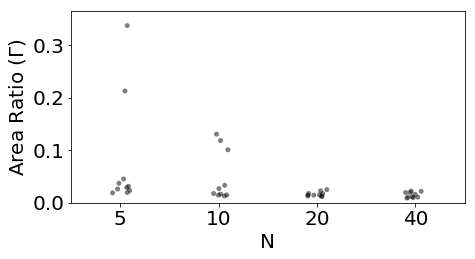

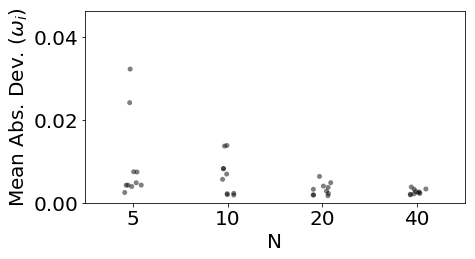

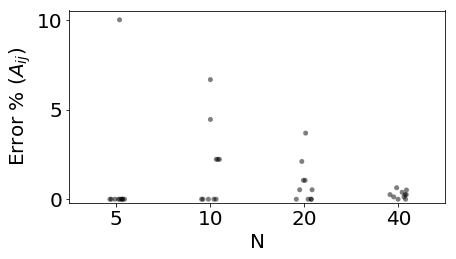

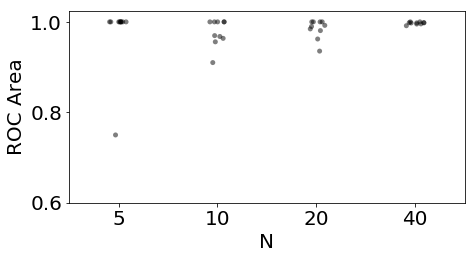

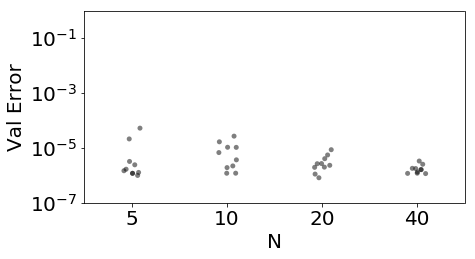

In [9]:
cat='Area ratio'
fig=plot_results(f_df,cat,plot_type='cat_plot')
cat='Mean absolute deviation'
fig=plot_results(w_df,cat,plot_type='cat_plot')
cat='Error rate'
fig=plot_results(A_df,cat,plot_type='cat_plot',ymin=-0.2)
cat='Area under ROC curve'
fig=plot_results(A_df,cat,plot_type='cat_plot',ymin=0.6)
cat='Validation Error'
fig=plot_results(e_df,cat,plot_type='cat_plot',yscale='log',ymin=0.0000001,ymax=1)